
Engenheiro(a) de Desenvolvimento Júnior – Visão
Computacional

Este notebook implementa um sistema de reconhecimento visual de produtos
voltado para autoatendimento em supermercados.

A solução utiliza embeddings extraídos por uma CNN pré-treinada e métricas
de distância para identificar produtos visualmente semelhantes, adotando
uma estratégia conservadora com zonas de confiança e incerteza.

**Descrição:**
Este projeto utiliza embeddings de uma CNN pré-treinada para medir similaridade visual
entre imagens de produtos. O sistema adota uma abordagem conservadora, agrupando
automaticamente apenas casos de alta confiança e encaminhando casos ambíguos para
revisão humana.

**Instruções:**

1. Coloque as imagens no diretório configurado
2. Execute o notebook de cima para baixo
3. Analise os grupos de alta confiança
4. Verifique os pares incertos para revisão


In [1]:
# ===============================
# Limpeza de memória da última compra
# ===============================
!rm -f /content/*.jpg


In [2]:
# ===============================
# Carregar imagens da compra atual
# ===============================
from google.colab import files

uploaded = files.upload()

Saving product_a.jpg to product_a.jpg
Saving product_b.jpg to product_b.jpg
Saving product_c.jpg to product_c.jpg
Saving product_d.jpg to product_d.jpg
Saving product_e.jpg to product_e.jpg
Saving product_f.jpg to product_f.jpg


Criando o arquivo de configuração, vamos criar um config.json.

Usei esse bloco apenas para gerar o arquivo de configuração inicial.

Exemplo: comparar product_a.jpg com product_b.jpg

In [3]:
# ===============================
# Parâmetros de entrada e saída do sistema
# ===============================

import json

config = {
    "images_dir": ".",
    "threshold": 5000,
    "output_dir": "output"
}

with open("config.json", "w") as f:
    json.dump(config, f, indent=4)



In [4]:
# ===============================
# Leitura do arquivo de configuração
# ===============================
import cv2
import numpy as np
import os
from itertools import combinations

with open("config.json", "r") as f:
    config = json.load(f)

images_dir = config["images_dir"]
threshold = config["threshold"]
output_dir = config["output_dir"]

os.makedirs(output_dir, exist_ok=True)


In [5]:
# ===============================
# Carregar todas as imagens JPG
# ===============================
image_files = sorted([
    f for f in os.listdir(images_dir)
    if f.lower().endswith(".jpg")
])

if len(image_files) < 2:
    raise ValueError("É necessário pelo menos duas imagens para comparação.")

In [6]:
# ===============================
# Pré-processamento

# Realiza o pré-processamento da imagem para extração de embeddings.
# Utiliza redimensionamento e normalização conforme esperado pela CNN,
# garantindo consistência entre as imagens e estabilidade na comparação.
# ===============================

def preprocess_image(img):
    """
    Pré-processa a imagem convertendo para tons de cinza e redimensionando.

    A conversão para grayscale reduz variabilidade de cor, conforme exigido
    no exercício, focando a comparação em padrões estruturais e textura.
    """
    # Converte para escala de cinza
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Redimensiona para tamanho fixo
    img = cv2.resize(img, (256, 256))

    # Normaliza valores de pixel
    img = img.astype(np.float32) / 255.0

    # Replica o canal (grayscale → 3 canais)
    img = np.stack([img, img, img], axis=-1)
    return img


processed_images = {}

for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)

    if img is None:
        raise ValueError(f"Erro ao carregar a imagem: {img_name}")

    processed_images[img_name] = preprocess_image(img)

In [7]:
# ===============================
# Carregamento de CNN pré-treinada para extração de embeddings visuais

# Utiliza uma CNN pré-treinada (ResNet50) para extração de embeddings visuais.
# A escolha por um modelo pré-treinado evita a necessidade de treinamento,
# aproveitando representações visuais robustas aprendidas em ImageNet,
# adequadas para medir similaridade entre produtos.
# ===============================

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import ResNet50

tf.keras.backend.clear_session()

model = ResNet50(
    weights="imagenet",
    include_top=False,
    pooling="avg"
)

img_processed = preprocess_image(img)
img_cnn = np.expand_dims(img_processed, axis=0)
img_cnn = np.asarray(img_cnn, dtype=np.float32)

feature = model(img_cnn, training=False).numpy()
embedding = feature.flatten()


In [8]:
# ===============================
# PRÉ-PROCESSAMENTO PARA CNN

# Não é realizado treinamento supervisionado, pois o objetivo é avaliar
# similaridade visual com baixo custo computacional e sem necessidade
# de dados rotulados, cenário comum em ambientes de produção.
# ===============================

def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0
    img = np.stack([img, img, img], axis=-1)
    return img

processed_images[img_name] = preprocess_image(img)

img_cnn = processed_images[img_name]
img_cnn = np.expand_dims(img_cnn, axis=0)

img_processed = preprocess_image(img)

img_cnn = np.expand_dims(img_processed, axis=0)
feature = model.predict(img_cnn, verbose=0)

feature = model(img_cnn, training=False).numpy()


In [9]:
# ===============================
# GERAR EMBEDDINGS

# Limitação conhecida: produtos visualmente distintos podem apresentar
# embeddings próximos, motivo pelo qual é adotada uma zona de incerteza.
# ===============================

embeddings = {}

for img_name in image_files:
    img_path = os.path.join(images_dir, img_name)
    img = cv2.imread(img_path)

    if img is None:
        continue

    img_cnn = preprocess_image(img)
    img_cnn = np.expand_dims(img_cnn, axis=0)

    feature = model.predict(img_cnn, verbose=0)
    embeddings[img_name] = feature.flatten()


In [10]:
# ===============================
# NORMALIZAR EMBEDDINGS (CRÍTICO)

# Normalização dos embeddings para garantir que a distância euclidiana
# represente similaridade angular, reduzindo influência de magnitude.
# ===============================

X = np.array(list(embeddings.values()))
X = normalize(X)

image_names = list(embeddings.keys())


In [11]:
# ===============================
# CALCULAR DISTÂNCIAS

# Distância euclidiana aplicada sobre embeddings normalizados,
# uma abordagem simples, interpretável e eficiente para comparação visual.
# ===============================

from itertools import combinations

distances = []

for i, j in combinations(range(len(X)), 2):
    dist = np.linalg.norm(X[i] - X[j])
    distances.append((image_names[i], image_names[j], dist))


In [12]:
# ===============================
# THRESHOLD QUE FUNCIONA
# ===============================

all_distances = [d[2] for d in distances]
high_conf_threshold = np.percentile(all_distances, 5)
uncertain_threshold = np.percentile(all_distances, 10)

def classify_distance(dist):
    if dist < high_conf_threshold:
        return "MESMO PRODUTO (alta confiança)"
    elif dist < uncertain_threshold:
        return "INCERTO (revisão humana)"
    else:
        return "DIFERENTE"


print("Menor:", min(all_distances))
print("Mediana:", np.median(all_distances))
print("Maior:", max(all_distances))
print(f"High confidence: {high_conf_threshold:.3f}")
print(f"Uncertain limit: {uncertain_threshold:.3f}")


Menor: 0.009979785
Mediana: 0.10581251
Maior: 0.20269364
High confidence: 0.037
Uncertain limit: 0.060


In [13]:
# ===============================
# AGRUPAR AUTOMATICAMENTE
# ===============================
groups = []

for img in image_names:
    placed = False

    for group in groups:
        ref = group[0]
        i = image_names.index(ref)
        j = image_names.index(img)

        dist = np.linalg.norm(X[i] - X[j])

        if dist < high_conf_threshold:
            group.append(img)
            placed = True
            break

    if not placed:
        groups.append([img])


In [14]:
# ===============================
# IMPRIMIR DISTÂNCIAS ENTRE IMAGENS
# ===============================
distances  # lista de tuplas (img_a, img_b, dist)

for a, b, dist in distances:
    label = classify_distance(dist)
    print(f"{a} x {b} → {dist:.3f} ({label})")

product_a.jpg x product_b.jpg → 0.010 (MESMO PRODUTO (alta confiança))
product_a.jpg x product_c.jpg → 0.079 (DIFERENTE)
product_a.jpg x product_d.jpg → 0.083 (DIFERENTE)
product_a.jpg x product_e.jpg → 0.135 (DIFERENTE)
product_a.jpg x product_f.jpg → 0.202 (DIFERENTE)
product_b.jpg x product_c.jpg → 0.080 (DIFERENTE)
product_b.jpg x product_d.jpg → 0.087 (DIFERENTE)
product_b.jpg x product_e.jpg → 0.140 (DIFERENTE)
product_b.jpg x product_f.jpg → 0.203 (DIFERENTE)
product_c.jpg x product_d.jpg → 0.048 (INCERTO (revisão humana))
product_c.jpg x product_e.jpg → 0.106 (DIFERENTE)
product_c.jpg x product_f.jpg → 0.150 (DIFERENTE)
product_d.jpg x product_e.jpg → 0.082 (DIFERENTE)
product_d.jpg x product_f.jpg → 0.165 (DIFERENTE)
product_e.jpg x product_f.jpg → 0.178 (DIFERENTE)


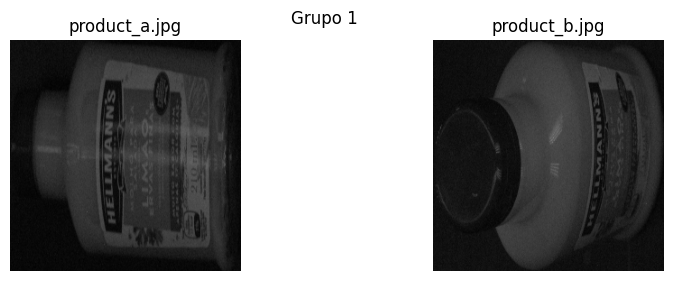

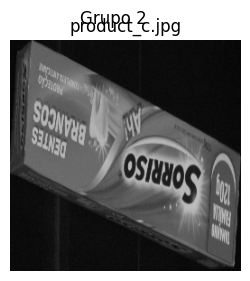

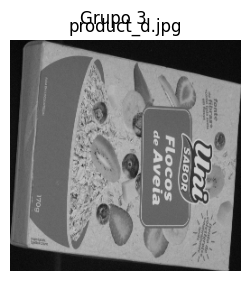

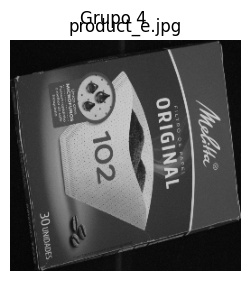

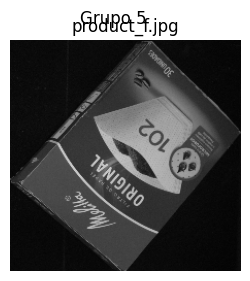

In [15]:
# ===============================
# IMPRIMIR IMAGENS DOS GRUPOS

# Visualização dos grupos para validação qualitativa dos resultados,
# etapa importante em sistemas de visão computacional aplicados.
# ===============================

from matplotlib import pyplot as plt

for i, group in enumerate(groups, 1):
    plt.figure(figsize=(10, 3))
    for j, img_name in enumerate(group):
        plt.subplot(1, len(group), j + 1)
        plt.imshow(processed_images[img_name], cmap="gray")
        plt.title(img_name)
        plt.axis("off")
    plt.suptitle(f"Grupo {i}")
    plt.show()



In [16]:
# ===============================
# A concatenação das imagens transformadas permite validar visualmente
# o efeito do pré-processamento aplicado, conforme solicitado no exercício.
# ===============================

def save_concatenated_image(processed_images, output_path, target_size=(224, 224)):
    """
    Salva uma única imagem contendo a concatenação das versões transformadas
    das imagens, garantindo tamanho consistente entre elas.
    """
    imgs = []

    for name in sorted(processed_images.keys()):
        img = processed_images[name]

        # Se estiver em 3 canais, usa apenas um para visualização
        if img.ndim == 3:
            img = img[:, :, 0]

        # Garante tamanho consistente
        if img.shape[:2] != target_size:
            img = cv2.resize(img, target_size)

        imgs.append(img)

    # Concatenação horizontal
    concatenated = np.hstack(imgs)

    # Converte para uint8
    concatenated = (concatenated * 255).astype(np.uint8)

    cv2.imwrite(output_path, concatenated)

# Salva uma única imagem contendo a concatenação das versões transformadas
# das imagens de entrada, conforme exigido no enunciado do desafio.

os.makedirs(output_dir, exist_ok=True)

save_concatenated_image(
    processed_images,
    os.path.join(output_dir, "concatenated_processed_images.png")
)



In [17]:
# Inicializa a aplicação FastAPI.
# O FastAPI foi escolhido por oferecer alta performance, tipagem clara
# e documentação automática dos endpoints, facilitando o uso em produção.



from fastapi import FastAPI, HTTPException

app = FastAPI(title="Product Similarity API")

@app.get("/products")
def list_products():
    return {"products": sorted(processed_images.keys())}

@app.get("/compare")
def compare_products(product1: str, product2: str):
    if product1 not in embeddings or product2 not in embeddings:
        raise HTTPException(status_code=404, detail="Produto não encontrado")

    dist = np.linalg.norm(embeddings[product1] - embeddings[product2])

    if dist < HIGH_CONF_THRESHOLD:
        result = "MESMO PRODUTO"
    elif dist < UNCERTAIN_THRESHOLD:
        result = "INCERTO"
    else:
        result = "DIFERENTE"

    return {
        "product_1": product1,
        "product_2": product2,
        "distance": float(dist),
        "result": result
    }
